In [1]:

import os
os.environ['RAY_DEDUP_LOGS'] = '0'

import numpy as np
import shap
import matplotlib.pyplot as plt
import json

from tempfile import TemporaryDirectory
from typing import List, Dict

import ray
from ray.tune import register_env
from ray.rllib.algorithms.algorithm import Algorithm
from ray.rllib.policy.policy import Policy

from ray.rllib.models import ModelCatalog
from eprllib.examples.example_central_agent_files.policy_model import CustomTransformerModel
ModelCatalog.register_custom_model("custom_transformer", CustomTransformerModel)

from eprllib.Environment.Environment import Environment
from eprllib.Environment.EnvironmentConfig import EnvironmentConfig
from eprllib.Agents.Filters.DefaultFilter import DefaultFilter
from eprllib.Agents.Triggers.SetpointTriggers import DualSetpointTriggerDiscreteAndAvailabilityTrigger
# from eprllib.Agents.Rewards.EnergyAndAshrae55SimpleModel import EnergyAndASHRAE55SimpleModel
from eprllib.Agents.Rewards.NygardFerguson1990 import NygardFerguson1990, NygardFerguson1990_comfort
from eprllib.AgentsConnectors.DefaultConnector import DefaultConnector

from eprllib.Agents.AgentSpec import (
    AgentSpec,
    ObservationSpec,
    RewardSpec,
    ActionSpec,
    TriggerSpec,
    FilterSpec
)
from eprllib.examples.example_thermostat_files.episode_fn import task_cofiguration
from eprllib.examples.example_thermostat_files.curriculum_learning import episode_fn
from eprllib.examples.example_thermostat_files.policy_mapping import policy_map_fn

from eprllib.PostProcess.Evaluation import generate_experience
from eprllib.AgentsConnectors.BaseConnector import BaseConnector

with open("C:/Users/grhen/Documents/GitHub2/eprllib/src/eprllib/examples/example_thermostat_files/curriculum_evaluation.json", "r") as f:
    episode_config = json.load(f)

In [2]:


checkpoint_path = "C:/Users/grhen/ray_results/07-CTD-I/20250909143536_Nygard-Ferguson-1990_PPO/Nygard-Ferguson-1990_PPO_7c3c4_00000/checkpoint_000008"
checkpoint_path = "C:/Users/grhen/ray_results/curriculum/task4/checkpoint_final"
checkpoint_path = "C:/Users/grhen/ray_results/curriculum/20250915195844-task1/PPO-9f13a_00000/checkpoint_000049"


In [3]:

"""
Esta configuración debe coincidir con la de entrenamiento.
"""
experiment_name = "07-CTD-I"
name = "weather-forecast-0p01"

eprllib_config = EnvironmentConfig()
eprllib_config.generals(
    epjson_path = "C:/Users/grhen/Documents/GitHub2/eprllib/src/eprllib/examples/example_central_agent_files/model.epJSON",
    epw_path = "C:/Users/grhen/Documents/GitHub2/eprllib/src/eprllib/examples/example_central_agent_files/weathers/ESP_PV_San.Sebastian-Igueldo.080270_TMYx.2004-2018.epw",
    output_path = TemporaryDirectory("output","",'C:/Users/grhen/Documents/Resultados_RLforEP').name,
    ep_terminal_output = True,
    timeout = 10,
    evaluation = True,
)

eprllib_config.connector(
    connector_fn = DefaultConnector,
    connector_fn_config = {},
)
eprllib_config.agents(
    agents_config = {
        "HVAC": AgentSpec(
            observation = ObservationSpec(
                variables = [
                    ("Site Outdoor Air Drybulb Temperature", "Environment"),
                    # ("Site Outdoor Air Relative Humidity", "Environment"),
                    ("Zone Mean Air Temperature", "Thermal Zone"),
                    # ("Zone Air Relative Humidity", "Thermal Zone"),
                    ("Zone People Occupant Count", "Thermal Zone"),
                    ("Zone Thermal Comfort Fanger Model PMV", "People")
                ],
                simulation_parameters = {
                    'hour': True,
                    'day_of_week': True,
                    'minutes': True,
                    'day_of_year': True,
                    # 'today_weather_horizontal_ir_at_time': True,
                },
                meters = [
                    "Electricity:Building",
                    "Heating:DistrictHeatingWater",
                    "Cooling:DistrictCooling",
                ],
                use_actuator_state = True,
                use_one_day_weather_prediction = True,
                weather_prediction_hours = 3,
                prediction_variables = {
                    'outdoor_dry_bulb': True,
                },
                internal_variables = [
                    ("Zone Floor Area", "Thermal Zone"),
                ],
                history_len=3,
                user_occupation_funtion = True,
                user_type = "Typical family, office job",
                zone_type = "daytime",
                occupation_schedule = ("Schedule:Constant", "Schedule Value", "occupancy_schedule"),
                user_occupation_forecast = True,
                occupation_prediction_hours = 3,
                summer_months = [11, 12, 1, 2],
                other_obs = {
                    "war_north": 0,  # Window-to-wall ratio north
                    "war_south": 0,  # Window-to-wall ratio south
                    "war_east": 0,   # Window-to-wall ratio east
                    "war_west": 0,   # Window-to-wall ratio west
                    "latitude": 0,  # Latitude
                    "longitude": 0,  # Longitude
                    # "elevation": 0,  # Elevation
                    # "time_zone": 0,  # Time zone
                }
            ),
            action = ActionSpec(
                actuators = [
                    ("Schedule:Compact", "Schedule Value", "heating_setpoint"),
                    ("Schedule:Compact", "Schedule Value", "cooling_setpoint"),
                    ("Schedule:Constant", "Schedule Value", "HVAC_OnOff"),
                ],
            ),
            filter= FilterSpec(
                filter_fn = DefaultFilter,
                filter_fn_config = {},
            ),
            trigger= TriggerSpec(
                trigger_fn = DualSetpointTriggerDiscreteAndAvailabilityTrigger,
                trigger_fn_config = {
                    'temperature_range': (17, 28),
                    "band_gap_range_len": 3,
                    "action_space_dim": 10,
                    'actuator_for_cooling': ("Schedule:Compact", "Schedule Value", "cooling_setpoint"),
                    'actuator_for_heating': ("Schedule:Compact", "Schedule Value", "heating_setpoint"),
                    'availability_actuator': ("Schedule:Constant", "Schedule Value", "HVAC_OnOff"),
                },
            ),
            reward = RewardSpec(
                reward_fn = NygardFerguson1990,
                reward_fn_config = {
                    "thermal_zone": "Thermal Zone",
                    "C2": 6000,
                    'people_name': "People",
                    'cooling_name': "Cooling:DistrictCooling",
                    'heating_name': "Heating:DistrictHeatingWater",
                    'cooling_energy_ref': 0,
                    'heating_energy_ref': 0,
                },
            ),
        ),
    }
)

eprllib_config.episodes(
    episode_fn = episode_fn,
    episode_fn_config = episode_config,
    cut_episode_len = 1
)

assert eprllib_config.agents_config is not None, "Agents configuration is not defined."

number_of_agents = len([keys for keys in eprllib_config.agents_config.keys()])
ray.init(_temp_dir='C:/Users/grhen/ray_results/tmp')
register_env(name="EPEnv", env_creator=lambda args: Environment(args))
env_config = eprllib_config.to_dict()

old_algo = Algorithm.from_checkpoint(checkpoint_path)

2025-09-16 10:04:29,399	INFO worker.py:1918 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 
c:\Users\grhen\Documents\GitHub2\eprllib\eprllib-dev\lib\site-packages\ray\rllib\algorithms\algorithm.py:520: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
c:\Users\grhen\Documents\GitHub2\eprllib\eprllib-dev\lib\site-packages\ray\tune\logger\unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))

In [4]:
# ray.shutdown()

In [5]:
single_policy = old_algo.get_policy("single_policy")

# Generate experience
df = generate_experience(
    env = Environment,
    env_config = env_config,
    policies = {
        "HVAC": single_policy,
    },
    num_episodes = 1
)

old_algo.stop()
ray.shutdown()

In [6]:
feature_names: Dict[str, List[str]] = {agent: [] for agent in env_config["agents_config"].keys()}
feature_names_index: Dict[str, Dict[str, int]] = {agent: {} for agent in env_config["agents_config"].keys()}
connector_fn: BaseConnector = env_config['connector_fn'](env_config["connector_fn_config"])

for agent in env_config["agents_config"].keys():
    connector_fn.get_agent_obs_dim(env_config,agent)
    feature_names_index[agent] = connector_fn.get_agent_obs_indexed(env_config,agent)
    for key in feature_names_index[agent].keys():
        feature_names[agent].append(key)

for agent in feature_names.keys():
    if env_config["agents_config"][agent]["observation"]["history_len"] > 1:
        feature_names_h = feature_names[agent].copy()
        for h in range(env_config["agents_config"][agent]["observation"]["history_len"]):
            feature_names_h_new: List[str] = []
            for value in feature_names_h:
                feature_names_h_new.append(f"h{h}_{value}")
            feature_names[agent].extend(feature_names_h_new)

In [7]:
feature_names

{'HVAC': ['HVAC: Site Outdoor Air Drybulb Temperature: Environment',
  'HVAC: Zone Mean Air Temperature: Thermal Zone',
  'HVAC: Zone People Occupant Count: Thermal Zone',
  'HVAC: Zone Thermal Comfort Fanger Model PMV: People',
  'HVAC: Zone Floor Area: Thermal Zone',
  'HVAC: Electricity:Building',
  'HVAC: Heating:DistrictHeatingWater',
  'HVAC: Cooling:DistrictCooling',
  'HVAC: day_of_week',
  'HVAC: day_of_year',
  'HVAC: hour',
  'HVAC: minutes',
  'HVAC: outdoor_dry_bulb: 1',
  'HVAC: outdoor_dry_bulb: 2',
  'HVAC: outdoor_dry_bulb: 3',
  'HVAC: war_north',
  'HVAC: war_south',
  'HVAC: war_east',
  'HVAC: war_west',
  'HVAC: latitude',
  'HVAC: longitude',
  'HVAC: time_zone',
  'HVAC: elevation',
  'HVAC: Schedule:Compact: Schedule Value: heating_setpoint',
  'HVAC: Schedule:Compact: Schedule Value: cooling_setpoint',
  'HVAC: Schedule:Constant: Schedule Value: HVAC_OnOff',
  'HVAC: User Occupation Forecast: 1',
  'HVAC: User Occupation Forecast: 2',
  'HVAC: User Occupation 

In [8]:
df

{'experiment': {'episode_1': {'timestep_1': {'HVAC': {'observation': array([[ 1.15500002e+01,  2.40000000e+01,  1.00000000e+00,
              0.00000000e+00,  2.00000000e+01,  0.00000000e+00,
              0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
              1.96672887e-01,  0.00000000e+00, -1.06293485e-01,
              9.23333359e+00,  8.85000038e+00,  8.56666660e+00,
              0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
              5.00000000e-01,  2.00000003e-01,  0.00000000e+00,
              0.00000000e+00, -7.44031727e-01, -6.72340989e-01,
             -1.00000000e+00,  9.23000000e+02,  8.50000024e-01,
              9.10000026e-01,  8.70000005e-01],
            [ 1.15500002e+01,  2.40000000e+01,  1.00000000e+00,
              0.00000000e+00,  2.00000000e+01,  0.00000000e+00,
              0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
              1.96672887e-01,  0.00000000e+00, -1.06293485e-01,
              9.23333359e+00,  8.85000038e+00,  8.566666

In [9]:
# for agent in feature_names_index.keys():
#     energy_total: List[float] = []
#     for timestep in range(1,len(df["experiment"]["episode_1"])):
#         energy_total.append(df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["observation"][feature_names_index[agent][f"{agent}: Heating:DistrictHeatingWater"]])
#         energy_total.append(df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["observation"][feature_names_index[agent][f"{agent}: Cooling:DistrictCooling"]])
#     print(sum(energy_total)/3600000)

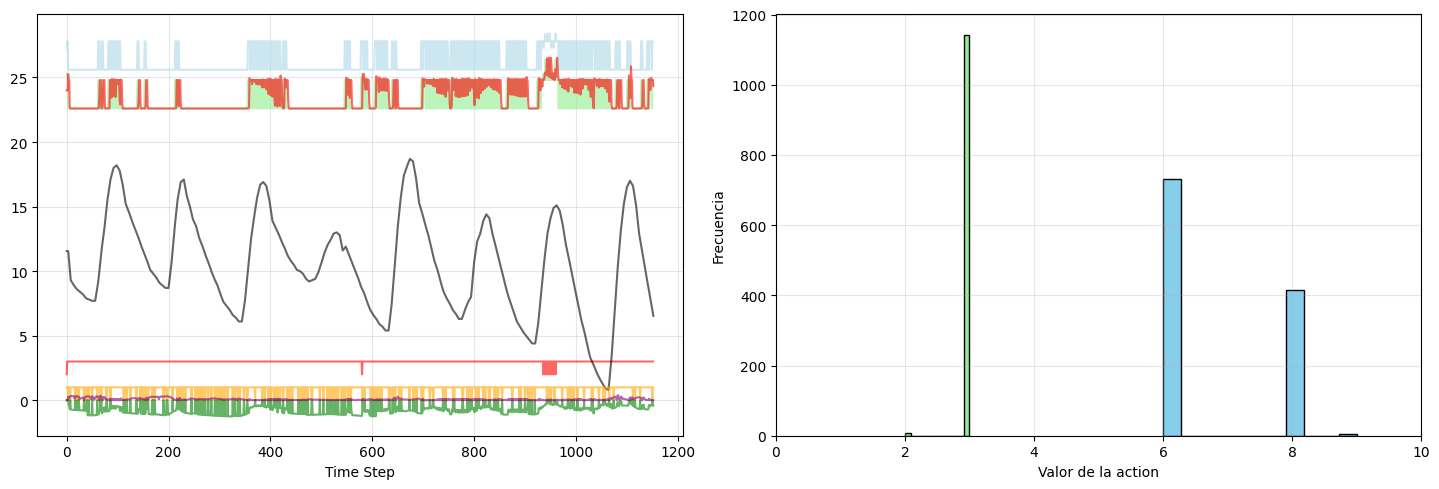

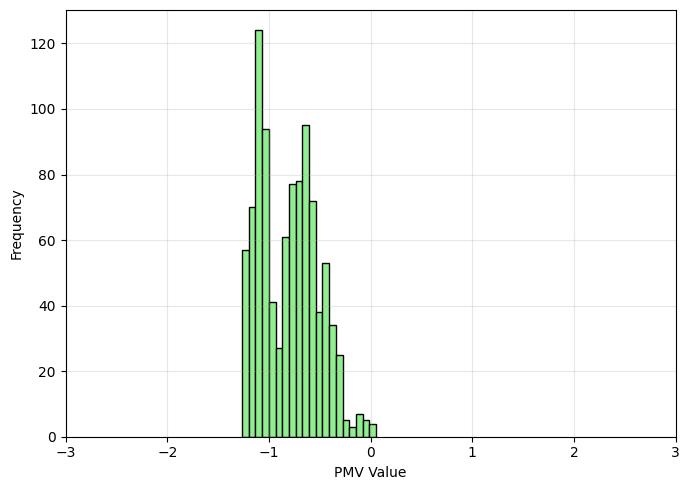


Statistical Summary (HVAC):
Mean: 2.99
Median: 3.00
Std Dev: 0.09
Min: 2.00
Max: 3.00
Mean: 6.73
Median: 6.00
Std Dev: 0.97
Min: 6.00
Max: 9.00
Total Energy Consumption (kWh): 84.75


In [10]:
from typing import Tuple
for agent in feature_names_index.keys():
    action_list_1: List[float] = []
    action_list_2: List[float] = []
    av_list: List[int] = []
    t_r_list: List[float] = []
    t_c_list: List[float] = []
    t_i_list: List[float] = []
    occ_list: List[float] = []
    t_out_list: List[float] = []
    energy_list: List[float] = []
    pmv_list: List[float] = []
    pmv_hist: List[float] = []
    for timestep in range(1,len(df["experiment"]["episode_1"])):
        t_i_list.append(df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["observation"][0][feature_names_index[agent][f"{agent}: Zone Mean Air Temperature: Thermal Zone"]])
        t_out_list.append(df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["observation"][0][feature_names_index[agent][f"{agent}: Site Outdoor Air Drybulb Temperature: Environment"]])
        energy_list.append(df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["observation"][0][feature_names_index[agent][f"{agent}: Heating:DistrictHeatingWater"]]/3600000)
        occ_t = df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["observation"][0][feature_names_index[agent][f"{agent}: Zone People Occupant Count: Thermal Zone"]]
        if occ_t > 0:
            occ_list.append(occ_t)
            pmv_list.append(df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["observation"][0][feature_names_index[agent][f"{agent}: Zone Thermal Comfort Fanger Model PMV: People"]])
            pmv_hist.append(df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["observation"][0][feature_names_index[agent][f"{agent}: Zone Thermal Comfort Fanger Model PMV: People"]])
        else:
            occ_list.append(0)
            pmv_list.append(0)
        
        if df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["action"] is None:
            pass
        else:
            a1 = df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["action"][0]
            a2 = df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["action"][1]
            action_list_1.append(a1)
            action_list_2.append(a2)
            temp_range = env_config["agents_config"][agent]["trigger"]["trigger_fn_config"]["temperature_range"]
            action_range: int = env_config["agents_config"][agent]["trigger"]["trigger_fn_config"]["action_space_dim"]
            if a1 > 0:
                t_r_list.append(min(temp_range)+((a2/action_range)*(max(temp_range)-min(temp_range)))+(a1-1)/2 + 1)
                t_c_list.append(min(temp_range)+((a2/action_range)*(max(temp_range)-min(temp_range)))-(a1-1)/2)
                av_list.append(a1)
            else:
                t_r_list.append(0)
                t_c_list.append(0)
                av_list.append(0)
    
    # print(action_list)
    # print(f"Agent: {agent}")
    
    # Create a figure with multiple subplots
    plt.figure(figsize=(14.5, 5))

    # 1. Time series plot
    plt.subplot(1, 2, 1)
    plt.plot(t_r_list, label='Tr', color='lightblue', alpha=0.6)
    plt.plot(t_c_list, label='Tc', color='lightgreen', alpha=0.6)
    plt.plot(av_list, label='Tc', color='red', alpha=0.6)
    plt.plot(t_i_list, label='Ti', color='red', alpha=0.6)
    plt.plot(t_out_list, label='To', color='black', alpha=0.6)
    plt.plot(occ_list, label='Occupancy', color='orange', alpha=0.6)
    plt.plot(pmv_list, label='PMV', color='green', alpha=0.6)
    plt.plot(energy_list, label='Energy', color='purple', alpha=0.6)
    plt.xlabel('Time Step')
    # plt.ylabel('Action Value')
    plt.grid(True, alpha=0.3)

    # 2. Histogram
    plt.subplot(1, 2, 2)
    plt.hist(action_list_2, bins=11, color='skyblue', edgecolor='black')
    plt.hist(action_list_1, bins=11, color='lightgreen', edgecolor='black')
    plt.xlabel('Valor de la action')
    plt.xlim((0, 10))
    plt.ylabel('Frecuencia')
    # plt.ylim((0, 1))
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 3. PMV histogram plot    
    plt.figure(figsize=(7, 5))
    plt.hist(pmv_hist, bins=20, color='lightgreen', edgecolor='black')
    plt.xlabel('PMV Value')
    plt.xlim((-3, 3))
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Basic statistical analysis
    print(f"\nStatistical Summary ({agent}):")
    print(f"Mean: {np.mean(action_list_1):.2f}")
    print(f"Median: {np.median(action_list_1):.2f}")
    print(f"Std Dev: {np.std(action_list_1):.2f}")
    print(f"Min: {np.min(action_list_1):.2f}")
    print(f"Max: {np.max(action_list_1):.2f}")
    print(f"Mean: {np.mean(action_list_2):.2f}")
    print(f"Median: {np.median(action_list_2):.2f}")
    print(f"Std Dev: {np.std(action_list_2):.2f}")
    print(f"Min: {np.min(action_list_2):.2f}")
    print(f"Max: {np.max(action_list_2):.2f}")
    print(f"Total Energy Consumption (kWh): {sum(energy_list):.2f}")


In [11]:
obs: List[float|int] = [-3,-2,-1,0,1,2,3]
rew: List[float] = []
for _ in range(len(obs)):
    rew.append(-(np.exp(obs[_]**2) - 1.0)/(np.exp(3**2)-1))
    
print(rew)

[np.float64(-1.0), np.float64(-0.006615353594489847), np.float64(-0.00021207899644323422), np.float64(-0.0), np.float64(-0.00021207899644323422), np.float64(-0.006615353594489847), np.float64(-1.0)]


In [12]:
norm_energy: List[float] = [1.0,0.75,0.5,0.25,0.0]
c: float = 6000 / (60/6) * (np.exp(3**2)-1)

rew_e: List[float] = []
for _ in range(len(norm_energy)):
    rew_e.append(-norm_energy[_] * (1 / c))
    
print(rew_e)

[np.float64(-2.0570839324364178e-07), np.float64(-1.5428129493273133e-07), np.float64(-1.0285419662182089e-07), np.float64(-5.1427098310910444e-08), np.float64(-0.0)]


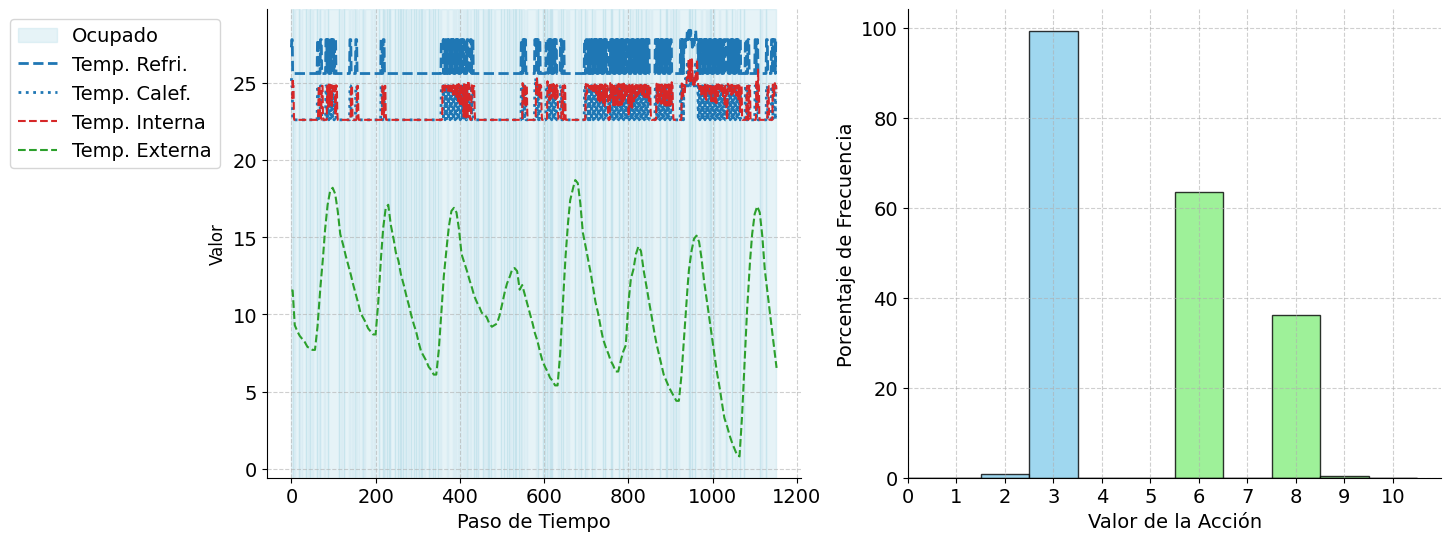

In [13]:
labelsize = 14
time_steps = np.arange(len(action_list_2))
time_steps_1 = np.arange(len(action_list_2)+1)
# --- Creación de la figura y subgráficas ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14.5, 6))
# fig.suptitle('Análisis de Control y Ocupación', fontsize=18, fontweight='bold', y=1.02)

# --- Subgráfica 1: Gráfico de series de tiempo ---
# Determinar y aplicar el color de fondo basado en la ocupación
is_occupied = False
start_occupancy = 0
for i, occ in enumerate(occ_list):
    if occ > 0 and not is_occupied:
        is_occupied = True
        start_occupancy = i
    elif occ == 0 and is_occupied:
        is_occupied = False
        end_occupancy = i
        # Usar axvspan para crear la región sombreada.
        # El color semi-transparente ayuda a ver las líneas del grid.
        ax1.axvspan(start_occupancy, end_occupancy, color='#ADD8E6', alpha=0.3, label='Ocupado' if start_occupancy == 0 else "")

# Dibujar las líneas de las series de tiempo sobre el fondo
ax1.plot(time_steps, t_r_list, label='Temp. Refri.', color='#1f77b4', linewidth=2, linestyle='--')
ax1.plot(time_steps, t_c_list, label='Temp. Calef.', color='#1f77b4', linewidth=2, linestyle=':')
ax1.plot(time_steps_1, t_i_list, label='Temp. Interna', color='#d62728', linestyle='--')
ax1.plot(time_steps_1, t_out_list, label='Temp. Externa', color='#2ca02c', linestyle='--')

# ax1.set_title('Valores de Control y Temperaturas', fontsize=14)
ax1.set_xlabel('Paso de Tiempo', fontsize=labelsize)
ax1.set_ylabel('Valor', fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=labelsize)
ax1.grid(True, linestyle='--', alpha=0.6)
# ax1.legend(loc='upper right')
ax1.legend(loc='upper left', bbox_to_anchor=(-0.5, 1), fontsize=labelsize)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# --- Subgráfica 2: Histograma normalizado ---
# Para obtener el porcentaje en el eje Y, usamos el argumento 'weights'.
total_actions = len(action_list_2)
weights = np.ones(total_actions) / total_actions * 100

n, bins, patches = ax2.hist(action_list_2, bins=np.arange(-0.5, 11.5, 1), weights=weights, color="#86EE80", edgecolor='black', alpha=0.8)
n, bins, patches = ax2.hist(action_list_1, bins=np.arange(-0.5, 11.5, 1), weights=weights, color='#87CEEB', edgecolor='black', alpha=0.8)
ax2.set_xlabel('Valor de la Acción', fontsize=labelsize)
ax2.set_ylabel('Porcentaje de Frecuencia', fontsize=labelsize)

# Aumentar el tamaño de la fuente para los valores de los ejes
ax2.tick_params(axis='both', which='major', labelsize=labelsize)
ax2.set_xlim(0, 11)
# Establecer los valores discretos en el eje horizontal
ax2.set_xticks(np.arange(0, 11))
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Mejorar el diseño del layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [14]:
# # Create a figure with multiple subplots
# plt.figure(figsize=(15.5, 5))

# # Histogram
# plt.hist(action_list, bins=30, color='skyblue', edgecolor='black')
# plt.title('Distribución de acciones')
# plt.xlabel('Valor de la action')
# plt.ylabel('Frecuencia')
# plt.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

In [15]:
# # Scatter plot of the variables action_list = df[agent]["actions"] vs cooling_energy = []
# action_list = df[agent]["actions"]
# cooling_energy = []
# for timestep in range(len(df[agent]["infos"])-1):
#     cooling_energy.append(df[agent]["infos"][timestep][f"{agent}: Cooling:DistrictCooling"])

# plt.figure(figsize=(7.5, 5))
# plt.scatter(action_list, cooling_energy, s=1)
# plt.xlabel("Action")
# plt.ylabel("Cooling energy")
# plt.title("Scatter plot of Action vs Cooling energy")
# plt.grid(True, alpha=0.3)
# plt.show()

In [16]:
# # Analyze transitions between actions
# transitions = np.diff(action_list)
# plt.figure(figsize=(10, 4))
# plt.plot(transitions, label='Action Changes')
# plt.title('Action Transitions Over Time')
# plt.xlabel('Time Step')
# plt.ylabel('Change in Action')
# plt.grid(True, alpha=0.3)
# plt.show()

# # Calculate transition statistics
# print("\nTransition Analysis:")
# print(f"Mean absolute change: {np.mean(np.abs(transitions)):.2f}")
# print(f"Max increase: {np.max(transitions):.2f}")
# print(f"Max decrease: {np.min(transitions):.2f}")


In [17]:
# # Create a figure with multiple subplots
# plt.figure(figsize=(15, 5))

# # 1. Time series plot
# plt.scatter(action_list, occ_list, color='blue', alpha=0.6)
# plt.title('Action-occupancy distribution')
# plt.xlabel('Action Value')
# plt.ylabel('Occupancy')
# plt.grid(True, alpha=0.3)

In [18]:
from typing import List, Any, Optional

agent:str = "HVAC"

feature_names_list: List[str] = feature_names[agent]

data_obs_list: List[Any] = []
for timestep in range(1,len(df["experiment"]["episode_1"])):
    if len(df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["observation"]) > 0:
        timestep_flattened: List[Any] = []
        for _ in range(len(df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["observation"])):
            timestep_flattened.extend(df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["observation"][_])
        data_obs_list.append(timestep_flattened)
    else:
        data_obs_list.append(df["experiment"]["episode_1"][f"timestep_{timestep}"][agent]["observation"])
        
data_obs = np.array(data_obs_list)

In [19]:
feature_names_list

['HVAC: Site Outdoor Air Drybulb Temperature: Environment',
 'HVAC: Zone Mean Air Temperature: Thermal Zone',
 'HVAC: Zone People Occupant Count: Thermal Zone',
 'HVAC: Zone Thermal Comfort Fanger Model PMV: People',
 'HVAC: Zone Floor Area: Thermal Zone',
 'HVAC: Electricity:Building',
 'HVAC: Heating:DistrictHeatingWater',
 'HVAC: Cooling:DistrictCooling',
 'HVAC: day_of_week',
 'HVAC: day_of_year',
 'HVAC: hour',
 'HVAC: minutes',
 'HVAC: outdoor_dry_bulb: 1',
 'HVAC: outdoor_dry_bulb: 2',
 'HVAC: outdoor_dry_bulb: 3',
 'HVAC: war_north',
 'HVAC: war_south',
 'HVAC: war_east',
 'HVAC: war_west',
 'HVAC: latitude',
 'HVAC: longitude',
 'HVAC: time_zone',
 'HVAC: elevation',
 'HVAC: Schedule:Compact: Schedule Value: heating_setpoint',
 'HVAC: Schedule:Compact: Schedule Value: cooling_setpoint',
 'HVAC: Schedule:Constant: Schedule Value: HVAC_OnOff',
 'HVAC: User Occupation Forecast: 1',
 'HVAC: User Occupation Forecast: 2',
 'HVAC: User Occupation Forecast: 3',
 'h0_HVAC: Site Outdoor

In [20]:
print(data_obs.shape)

(1153, 87)


In [21]:
from numpy.typing import NDArray
from numpy import float32
import torch
# Model prediction function (adapted for RLlib)
POLICY: Optional[Policy] = None
def model_predict(
    data: NDArray[float32],
):
    # Transform the lists in tensors.
    obs_tensor = torch.tensor(data, dtype=torch.float32)
    
    # Compute the actions.
    with torch.no_grad():
        predictions = POLICY.compute_actions(
            obs_batch=obs_tensor.numpy(), 
            exploration=False, 
        )[0]
    return predictions

In [22]:
# Use KernelExplainer
data_obs_sample = shap.sample(data_obs, 100)

POLICY = single_policy
explainer = shap.KernelExplainer(
    model_predict,
    data=data_obs_sample,
    feature_names=feature_names_list
    )

Provided model function fails when applied to the provided data set.


RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x87 and 29x128)

In [ ]:
background_data_np_sample = shap.sample(data_obs, 50)

In [ ]:
shap_values_1 = explainer(background_data_np_sample)

  0%|          | 0/50 [00:00<?, ?it/s]

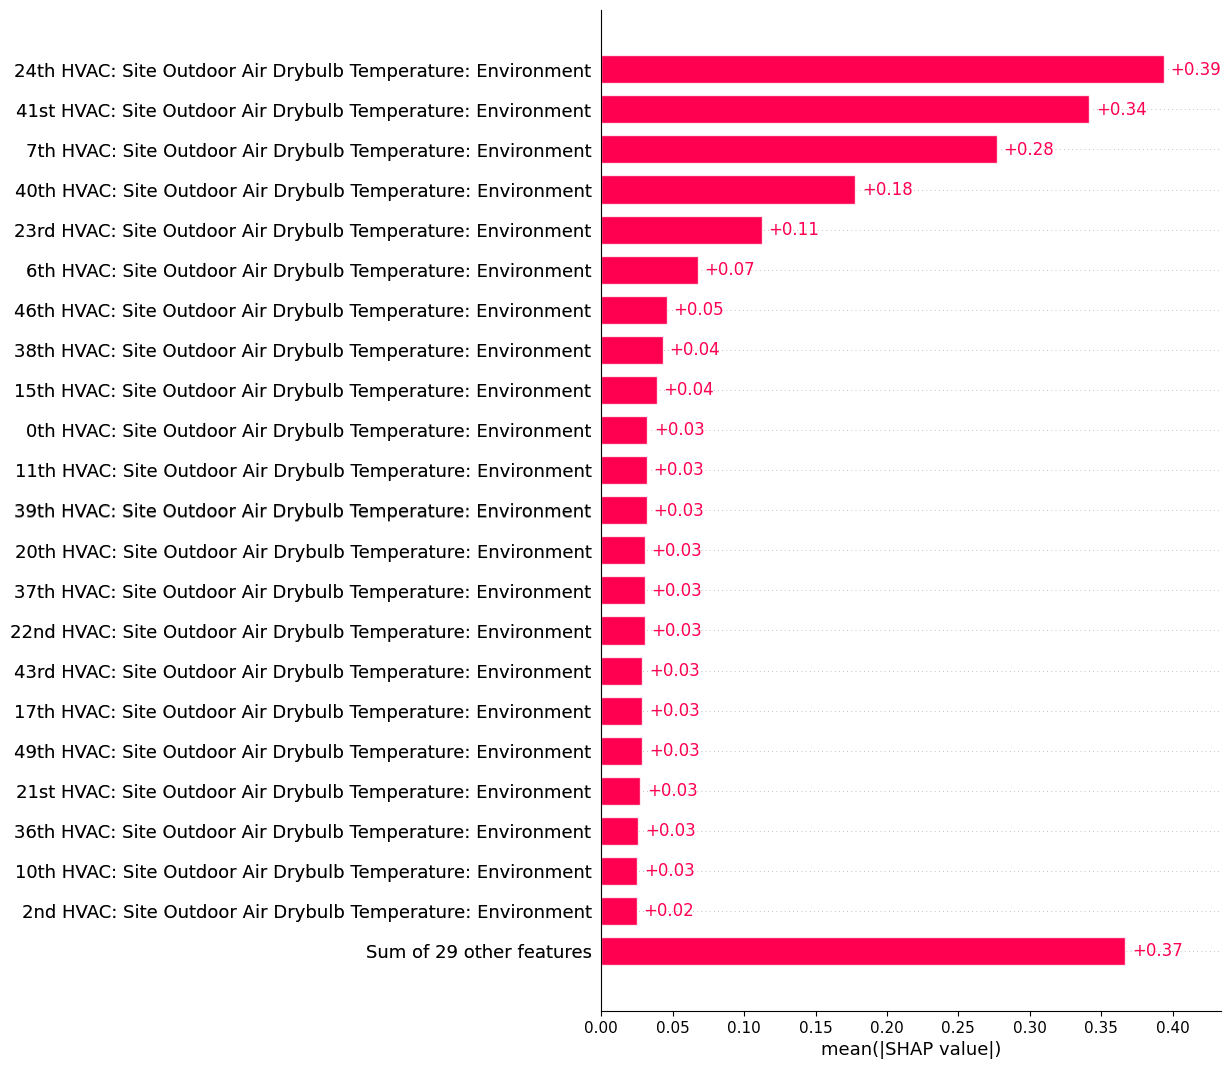

In [ ]:
"""
Global bar plot
================

Passing a matrix of SHAP values to the bar plot function creates a global feature importance 
plot, where the global importance of each feature is taken to be the mean absolute value for 
that feature over all the given samples.

# By default the bar plot only shows a maximum of ten bars, but this can be controlled with the `max_display` parameter.
"""
shap.plots.bar(shap_values_1, max_display=23)

In [ ]:
# for _ in range(50):
#     shap.plots.bar(shap_values_1[_], max_display=13)

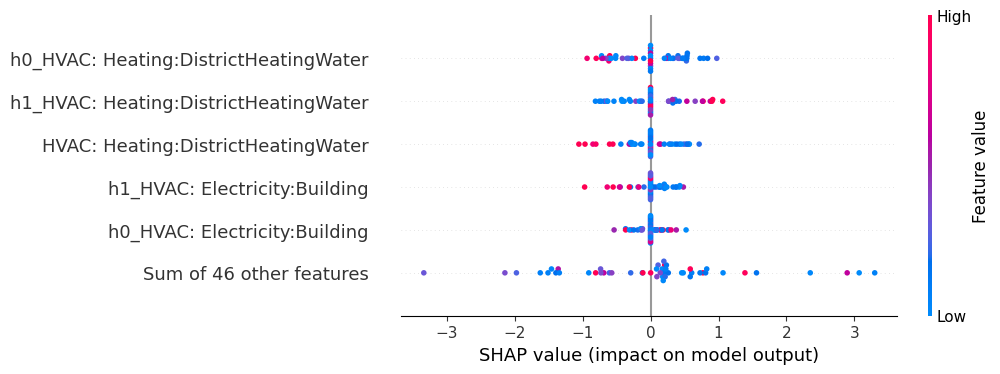

In [ ]:
"""
beeswarm summary plot
======================

The beeswarm plot is designed to display an information-dense summary of how the top features 
in a dataset impact the model’s output. Each instance the given explanation is represented by 
a single dot on each feature row. The x position of the dot is determined by the SHAP value 
(shap_values.value[instance,feature]) of that feature, and dots “pile up” along each feature row 
to show density. Color is used to display the original value of a feature 
(shap_values.data[instance,feature]).

By default the maximum number of features shown is ten, but this can be adjusted with the max_display parameter.
"""
shap.plots.beeswarm(shap_values_1, max_display=6)

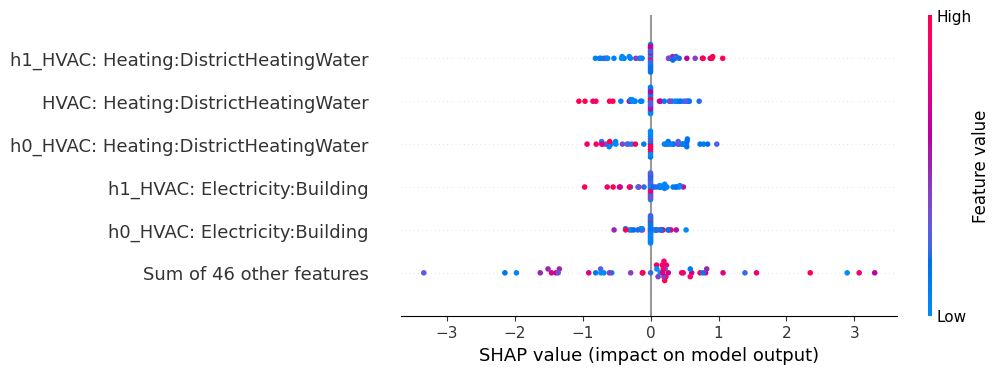

In [ ]:
"""
Feature ordering
=================

By default the features are ordered using shap_values.abs.mean(0), which is the mean absolute value 
of the SHAP values for each feature. This order however places more emphasis on broad average impact, 
and less on rare but high magnitude impacts. If we want to find features with high impacts for individual 
people we can instead sort by the max absolute value.
"""
shap.plots.beeswarm(shap_values_1, max_display=6, order=shap_values_1.abs.max(0))

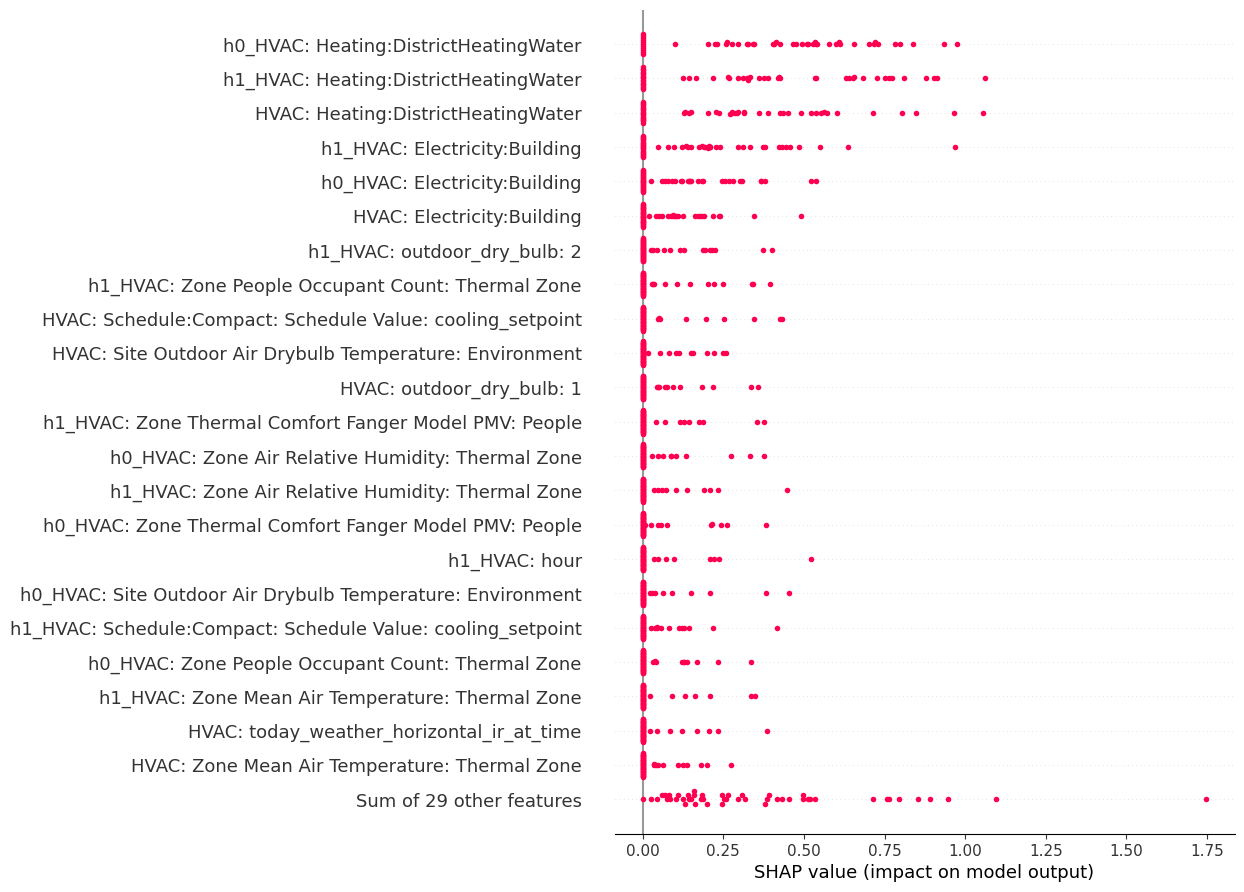

In [ ]:
"""
Sometimes it is helpful to transform the SHAP values before we plots them. Below we plot the absolute 
value and fix the color to be red. This creates a richer parallel to the standard shap_values.abs.mean(0) 
bar plot, since the bar plot just plots the mean value of the dots in the beeswarm plot.
"""
shap.plots.beeswarm(shap_values_1.abs, max_display=23, color="shap_red")

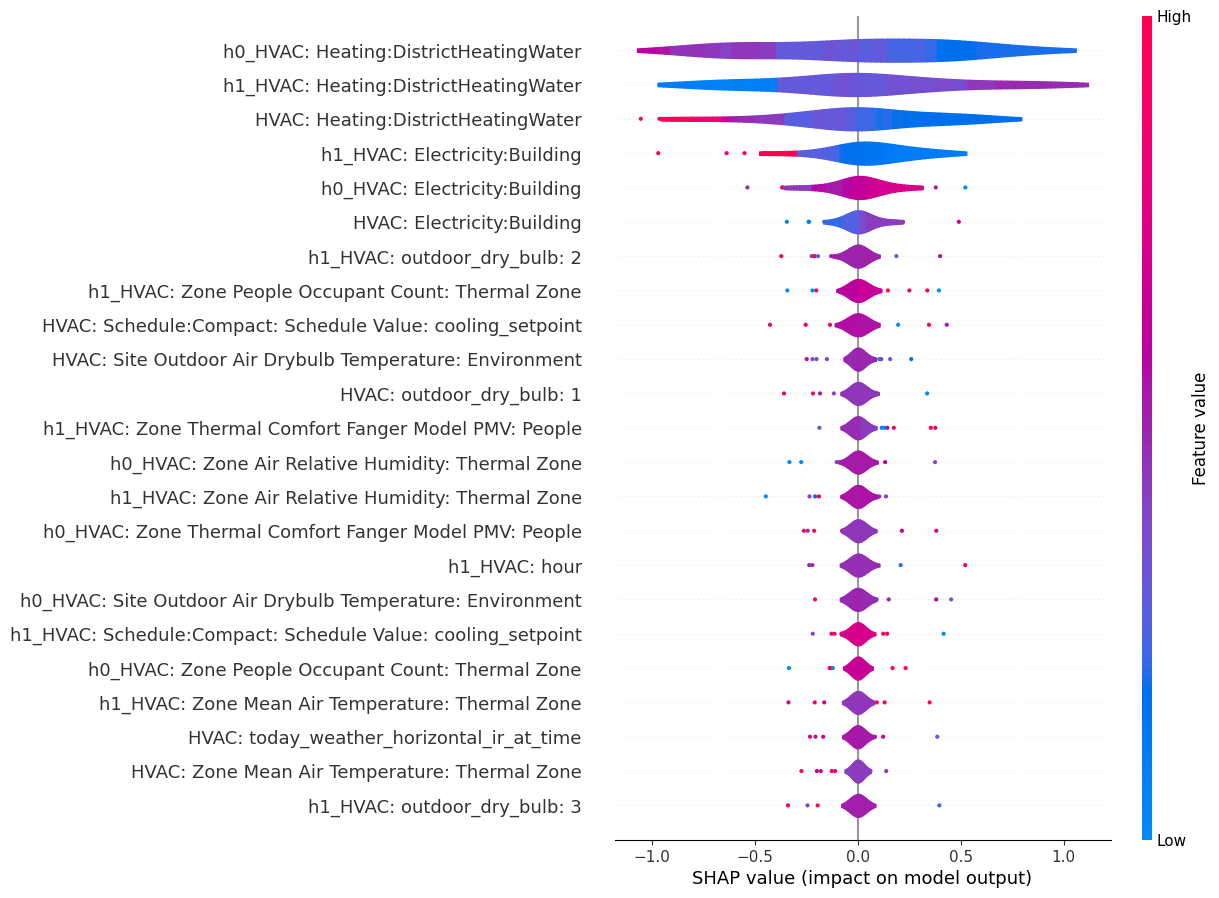

In [ ]:
"""
A simple violin summary plot
=============================

The violin summary plot offers a compact representation of the distribution and variability of SHAP 
values for each feature. Individual violin plots are stacked by importance of the particular feature 
on model output (sum of the absolute values of the SHAP values per feature).

Violin plots use “violin-shaped” figures to display the distribution and density of SHAP values for their 
respective feature. The violins can therefore provide insights into the range, variability, skewness, 
symmetry, and multimodality of the SHAP value distribution for a specific feature.

The overall violin summary plot allow for comparisons in feature importance. Wider violins indicate higher 
density and more frequent values, thus providing insights into the relative importance of each feature with 
regard to the model output.
"""
shap.plots.violin(shap_values_1, max_display=23)

In [ ]:
"""
Simple dependence scatter plot
===============================

A dependence scatter plot shows the effect a single feature has on the predictions made by the model.

* Each dot is a single prediction (row) from the dataset.
* The x-axis is the value of the feature (from the X matrix, stored in explanation.data).
* The y-axis is the SHAP value for that feature (stored in explanation.values), which represents how much knowing 
that feature’s value changes the output of the model for that sample’s prediction. For this model the units are 
log-odds of making over 50k annually.
* The light grey area at the bottom of the plot is a histogram showing the distribution of data values.
"""

features = feature_names.copy()

# for feature in features:
#     shap.plots.scatter(
#         shap_values_1[:, feature],
#         # color=shap_values_1[:, "Zone Thermal Comfort Fanger Model PMV"]
#         )

In [ ]:

# # for feature in features:
# features_copy = features.copy()
# features_copy.remove("Estado del actuador")
# for feature2 in features_copy:
#     shap.plots.scatter(
#         shap_values_1[:, "Estado del actuador"],
#         color=shap_values_1[:, feature2]
#         )

In [ ]:
shap.plots.scatter(
    shap_values_1[:, "Energía para enfriamiento"],
    color=shap_values_1[:, "Temperatura de bulbo seco"]
    )

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

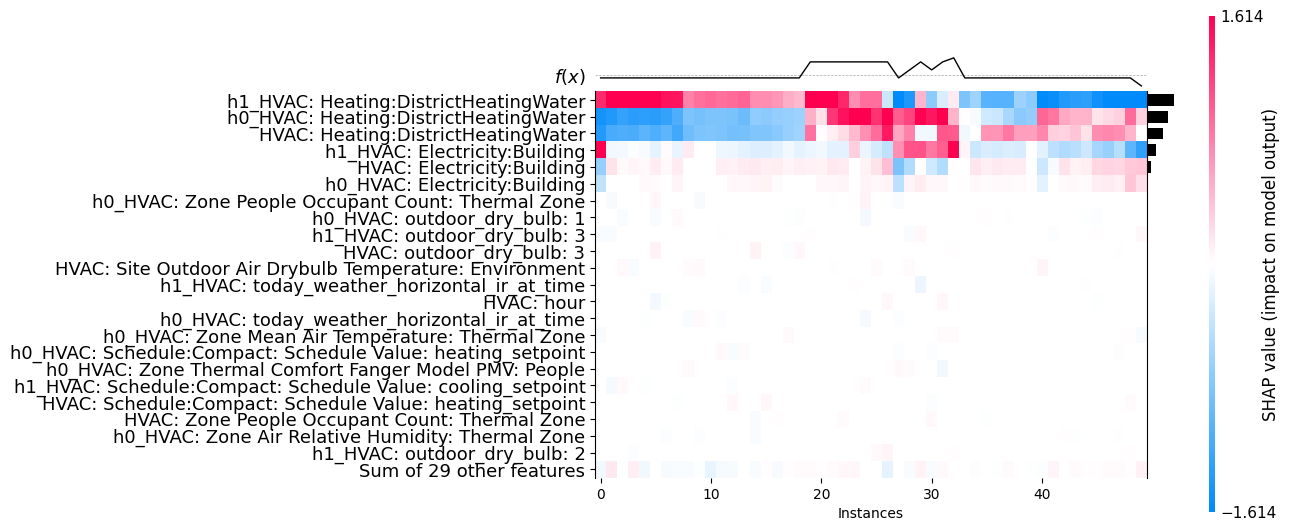

<Axes: xlabel='Instances'>

In [ ]:
"""
Heatmap
========

Passing a matrix of SHAP values to the heatmap plot function creates a plot with the instances on the x-axis, 
the model inputs on the y-axis, and the SHAP values encoded on a color scale. By default the samples are ordered 
using shap.order.hclust, which orders the samples based on a hierarchical clustering by their explanation 
similarity. This results in samples that have the same model output for the same reason getting grouped together 
(such as people with a high impact from capital gain in the plot below).

The output of the model is shown above the heatmap matrix (centered around the explaination’s .base_value), and 
the global importance of each model input shown as a bar plot on the right hand side of the plot (by default this 
is the shap.order.abs.mean measure of overall importance).
"""
shap.plots.heatmap(shap_values_1, max_display=23)

In [ ]:
# for i in range(len(background_data_np_sample)):
#     shap.initjs()
#     shap.force_plot(explainer.expected_value, shap_values[i], background_data_np_sample[i], matplotlib=True, show=True)

# for i in range(14):
#     shap.dependence_plot(i, shap_values, background_data_np_sample)

In [ ]:
# Parameter importance

# import eli5
# from eli5.sklearn import PermutationImportance

# val_X = df["observations"][0:100]
# val_y = df["actions"][0:100]

# perm = PermutationImportance(model_predict, random_state=1).fit(val_X, val_y)
# eli5.show_weights(perm, feature_names = val_X.columns.tolist())